<a href="https://colab.research.google.com/github/Elahehsrz/PlantUML-Generation/blob/main/PlantUML_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing and importing libraries

In [ ]:
pip install datasets


In [ ]:
pip install langchain-cohere

In [ ]:
pip install langchain-plantuml

In [ ]:
pip install langchain_community


In [9]:
from datasets import load_dataset
from langchain import OpenAI, LLMChain, PromptTemplate
from langchain.memory import ConversationBufferMemory
from langchain_plantuml import diagram
import pandas as pd
import cohere


## Data

In [6]:
data= "coai/plantuml_generation"

In [ ]:
dataset = load_dataset(data)

In [8]:
train_dataset = load_dataset(data, split='train')
train_dataset


Dataset({
    features: ['text'],
    num_rows: 1940
})

In [12]:
train_df = dataset['train'].to_pandas()
train_df

,text
0,"<s>[INST]\nFor the given description, generate..."
1,"<s>[INST]\nFor the given description, generate..."
2,"<s>[INST]\nFor the given description, generate..."
3,"<s>[INST]\nFor the given description, generate..."
4,"<s>[INST]\nFor the given description, generate..."
...,...
1935,<s>[INST]\nFor the Domain Fashion and Beauty a...
1936,<s>[INST]\nFor the Domain Fashion and Beauty a...
1937,<s>[INST]\nFor the Domain Fashion and Beauty a...
1938,<s>[INST]\nFor the Domain Fashion and Beauty a...


In [13]:
def process_dataframe(df):
    # Add new columns "prompt" and "completion"
    df['scenario'] = ""
    df['PlantUML code'] = ""

    # Iterate through rows to split the text
    for index, row in df.iterrows():
        text = row['text']
        split_marker = "The basic syntax for the diagram is as follows"
        if split_marker in text:
            prompt, completion = text.split(split_marker, 1)
            df.at[index, 'scenario'] = prompt.strip() + " " + split_marker
            df.at[index, 'PlantUML code'] = completion.strip()
        else:
            df.at[index, 'scenario'] = text.strip()
            df.at[index, 'PlantUML code'] = ""

    # Delete the column "text"
    df.drop(columns=['text'], inplace=True)

    # Return the new dataframe
    return df

In [14]:
new_dataframe = process_dataframe(train_df)
new_dataframe

,scenario,PlantUML code
0,"<s>[INST]\nFor the given description, generate...",:\n@startuml\nparticipant User as U\nparticipa...
1,"<s>[INST]\nFor the given description, generate...",:\n\n@startuml\nleft to right direction\nactor...
2,"<s>[INST]\nFor the given description, generate...",:\n\n@startuml\nclass Order {\n +orderId: int...
3,"<s>[INST]\nFor the given description, generate...",:\n\n@startuml\nobject Order1 {\n orderId = 1...
4,"<s>[INST]\nFor the given description, generate...",:\n\n@startuml\n[*] --> NewOrder\nNewOrder -->...
...,...,...
1935,<s>[INST]\nFor the Domain Fashion and Beauty a...,
1936,<s>[INST]\nFor the Domain Fashion and Beauty a...,
1937,<s>[INST]\nFor the Domain Fashion and Beauty a...,
1938,<s>[INST]\nFor the Domain Fashion and Beauty a...,


In [15]:
def count_empty_completions(df):
    # Count the rows where 'completion' column has only spaces or is empty
    count = df['PlantUML code'].apply(lambda x: x.strip() == '').sum()
    return count

In [16]:
def drop_empty_completion_rows(df):
    # Drop rows where 'completion' column is empty
    df = df[df['PlantUML code'].str.strip() != '']
    return df

In [17]:
count_empty_completions(new_dataframe)


971

In [18]:
df2 = drop_empty_completion_rows(new_dataframe)
df2

,scenario,PlantUML code
0,"<s>[INST]\nFor the given description, generate...",:\n@startuml\nparticipant User as U\nparticipa...
1,"<s>[INST]\nFor the given description, generate...",:\n\n@startuml\nleft to right direction\nactor...
2,"<s>[INST]\nFor the given description, generate...",:\n\n@startuml\nclass Order {\n +orderId: int...
3,"<s>[INST]\nFor the given description, generate...",:\n\n@startuml\nobject Order1 {\n orderId = 1...
4,"<s>[INST]\nFor the given description, generate...",:\n\n@startuml\n[*] --> NewOrder\nNewOrder -->...
...,...,...
965,"<s>[INST]\nFor the given description, generate...",:\n\n@startuml\nclass Order {\n +orderId: int...
966,"<s>[INST]\nFor the given description, generate...",:\n\n@startuml\nclass Order {\n +orderId: int...
967,"<s>[INST]\nFor the given description, generate...",:\n\n@startuml\nclass Order {\n +orderId: int...
968,"<s>[INST]\nFor the given description, generate...",":\n\n@startuml\npackage ""E-Commerce System"" {\..."


## PlantUML Generation

In [ ]:
API_KEY = ""

In [11]:
co = cohere.Client(API_KEY)

In [20]:
scenario1 = df2['PlantUML code'][1]
scenario1

":\n\n@startuml\nleft to right direction\nactor User\nactor Admin\nUser --> (Place Order)\nUser --> (Track Order)\nAdmin --> (Manage Orders)\n@enduml\n\n[/INST]@startuml\nleft to right direction\nactor User\nactor MobileApp\nUser --> (Open Mobile App)\nUser --> (Log in to Account)\nUser --> (Navigate to Messaging Section)\nUser --> (Create New Text Message)\nUser --> (Enter Recipient's Phone Number)\nUser --> (Type Message Content)\nUser --> (Send Message)\nMobileApp --> (Validate Recipient's Phone Number and Message Content)\nMobileApp --> (Send Message to Recipient's Phone Number)\nUser --> (Receive Confirmation Message)\nUser --> (Prompted to Log in)\nUser --> (Prompted to Connect to Internet)\nUser --> (Prompted to Enter Valid Phone Number)\n\nnote left of MobileApp\n- Access User's Contacts\n- Validate Phone Number Format\n- Limit Message Length\nend note\n\nnote right of MobileApp\n- Attach Files or Images\n- Schedule Message Sending\nend note\n\nUser --> (Receive Birthday Messag

In [21]:
response = co.chat(
  model="command-r-plus",
  message=scenario1)

print(response.text)

Here is the corrected code:

```
@startuml
left to right direction
actor User
actor Admin
actor MobileApp

User --> MobileApp : Open Mobile App
User --> MobileApp : Log in to Account
User --> MobileApp : Navigate to Messaging Section
User --> MobileApp : Create New Text Message
User --> MobileApp : Enter Recipient's Phone Number
User --> MobileApp : Type Message Content
User --> MobileApp : Send Message
MobileApp --> User : Receive Confirmation Message
MobileApp --> User : Prompted to Log in
MobileApp --> User : Prompted to Connect to Internet
MobileApp --> User : Prompted to Enter Valid Phone Number
MobileApp --> (Validate Recipient's Phone Number and Message Content)
MobileApp --> (Send Message to Recipient's Phone Number)

note left of MobileApp : <br/>- Access User's Contacts<br/>- Validate Phone Number Format<br/>- Limit Message Length

note right of MobileApp : <br/>- Attach Files or Images<br/>- Schedule Message Sending

User --> (Receive Birthday Message)
User --> (Reply to Bir

Let's try the results in: https://www.plantuml.com/plantuml/uml/SyfFKj2rKt3CoKnELR1Io4ZDoSa70000

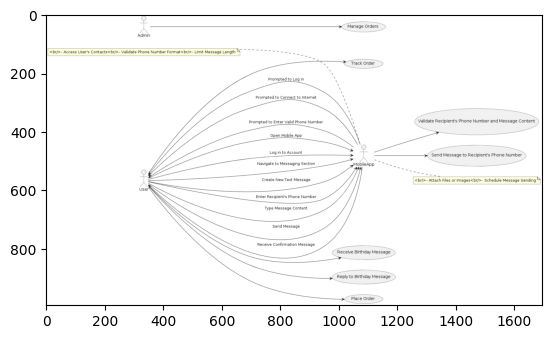

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('PlantUML1.png')
imgplot = plt.imshow(img)
plt.show()
